In [1]:
#from pyscf import gto, scf, fci, lo
#import netket as nk; import netket.experimental as nkx
import numpy as np
import time
#import itertools
import qiskit
#from qiskit.quantum_info import Pauli, SparsePauliOp
from collections import defaultdict
#import tensorflow as tf
import sys
import os
import pandas as pd
#import itertools
from itertools import product
import matplotlib.pyplot as plt
#sys.path.append(os.path.dirname(os.getcwd()) + "/SAMPLER_LOCAL_IMPORT")
#from Sampling_Quantum import *
#from New_MCMC_Proposal import *
#sys.path.append(os.getcwd() + "/Code_download_Bell_2")
from MCMC_funs_Leyden import *

print(qiskit.version.get_version_info())
os.getcwd()

1.0.2


"c:\\Users\\vinit\\Downloads\\Research\\Quantum-Sampling\\Manas' Proposals"

## Non-vectorized HMC

In [104]:
def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]



def Sampling_MCMC_trajectories(problem_inst, Transition_matrix, sample_size=10000, 
                               burn=1000, method='Quantum', init_config=None):

    n = problem_inst.n
    beta = problem_inst.T
    prob_dist = np.zeros(2**n)

    #exact_dist = np.exp(-beta * Proposal_object.Energy_array)
    #exact_dist = exact_dist / np.sum(exact_dist)

    #err_hist = []
    key_list = []

    if init_config==None:
        s = np.random.choice([1,-1],size=n)
    else: s = init_config

    int_key = spinconf2int(s)
    #print(int_key)
    
    for k in range(burn):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
         int_key = generate_move(transition_mat=Transition_matrix, state=int_key)

    for k in range(sample_size):
        #s = Proposal_object.generate_MCMC_trajectories(Transition_matrix, s)
        int_key = generate_move(transition_mat=Transition_matrix, state=int_key)
        #key = spinconf2int(s)
        prob_dist[int_key] +=1
        key_list.append(int_key)

    
    return np.flip(prob_dist/np.sum(prob_dist)), key_list




#Continuous variable encoding (Hamiltonian Monte Carlo, Adaptive MCMC)
#*********************************************************************


def normalize_transition_matrix(T, eps=1e-12, verbose=False):
   
    T = np.copy(T)  
    T[T < 0] = 0.0  

    for j in range(T.shape[1]):
        col_sum = T[:, j].sum()
        if abs(col_sum) > eps:
            T[:, j] /= abs(col_sum)
        else:
            # Uniform fallback for ill-defined columns
            T[:, j] = 1.0 / T.shape[0]
            if verbose:
                print(f"Warning: column {j} had zero or near-zero sum. Reset to uniform.")

    # Validate after normalization
    if verbose:
        for j in range(T.shape[1]):
            if not np.isclose(T[:, j].sum(), 1.0, atol=1e-6):
                print(f"Column {j} sum = {T[:, j].sum()} (should be 1.0)")
            if np.any(T[:, j] < 0):
                print(f"Negative entries found in column {j}: {T[:, j][T[:, j] < 0]}")

    return T



def grad_U(x, J, h, alpha):
    #v = np.sign(np.tanh(alpha * x))
    t = np.tanh(alpha * x)
    sech_sq = 1.0 * (1 - t ** 2)
    return alpha * sech_sq * (h + J @ t)  #Assuming J is symmetric; Otherwise multiply by 2. 

def leapfrog_integrator(x, p, grad_U, epsilon, L, J, h, alpha):
    # Integrates hamilton's eqn of motion
    x_new = np.copy(x)
    p_new = np.copy(p) - 0.5 * epsilon * grad_U(x_new, J, h, alpha)
    for _ in range(L):
        x_new += epsilon * p_new
        if _ != L - 1:
            p_new -= epsilon * grad_U(x_new, J, h, alpha)
        x_list.append(x_new.copy())
    p_new -= 0.5 * epsilon * grad_U(x_new, J, h, alpha)
    return x_new, p_new

p_global = []
def HMC_step(v, problem_inst, epsilon, L, alpha=2.0, num_p_samples=10):
    """HMC update for binary v using multiple momentum samples"""
    J_Q = problem_inst.J_quantum
    h_Q = problem_inst.h_quantum
    n = problem_inst.n
    beta = problem_inst.T
    
    x = np.arctanh(np.clip(v, -0.999, 0.999)) / alpha
    counts = {}

    for _ in range(num_p_samples):
        p = np.random.normal(size=n)
        p_global.append(p)

        v_old = np.sign(np.tanh(alpha * x))
        
        #U_x_init = config_energies[2**n - Proposal_object.get_spinconfig_to_int(v_old)-1]
        U_x_init = problem_inst.E_arr[::-1][spinconf2int(v_old)]
        H_init = 0.5 * np.sum(p**2) + U_x_init

        x_new, p_new = leapfrog_integrator(x, p, grad_U, epsilon, L, J_Q, h_Q, alpha)
        v_new = np.sign(np.tanh(alpha * x_new))

        U_x_final = problem_inst.E_arr[::-1][spinconf2int(v_new)]
        H_final = 0.5 * np.sum(p_new**2) + U_x_final

        accept_prob = min(1.0, np.exp(-(beta*H_final - beta*H_init)))

  
        if np.random.rand() < accept_prob:
            v_tuple = tuple(v_new.astype(int))
        else:
            v_tuple = tuple(v.astype(int))

        counts[v_tuple] = counts.get(v_tuple, 0) + 1

    return counts


def HMC_T_matrix(problem_inst, epsilon=0.1, L=10, alpha=3.0, num_samples=100, num_p_samples=10):

    from tqdm import tqdm

    n = problem_inst.n
    
    configs = all_configs(n)
    idx_map = {tuple(c): i for i, c in enumerate(configs)}
    T = np.zeros((2**n, 2**n))

    for v in tqdm(configs, desc="Building T matrix"):
        aggregate_counts = {}
        
        for _ in range(num_samples):
            counts = HMC_step(np.array(v),problem_inst, epsilon, L, alpha, num_p_samples)

            for k, val in counts.items():
                aggregate_counts[k] = aggregate_counts.get(k, 0) + val
    
        i = idx_map[tuple(v)]
        total = sum(aggregate_counts.values())
        for v_prime, c in aggregate_counts.items():
            
            j = idx_map[v_prime]
            if j != i :
                T[j, i] = c / total
            #if j != i:
            #    T[i, j] = c / total

            #else:
        T[i,i] = 1-sum(T[:,i])    

    T = normalize_transition_matrix(T, eps=1e-12, verbose=True)

    return T


{(-1, -1, -1, -1): 6985, (-1, 1, -1, -1): 905, (1, -1, -1, -1): 449, (1, 1, -1, -1): 467, (-1, 1, -1, 1): 89, (-1, -1, 1, -1): 73, (-1, -1, 1, 1): 22, (1, -1, 1, -1): 9, (-1, 1, 1, 1): 1}


Text(0.5, 1.0, 'HMC Proposal Distribution')

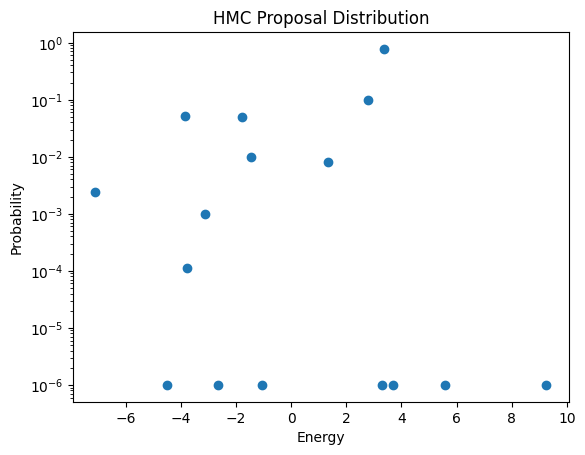

In [116]:
sample_size=1000

np.random.seed(42)
J = np.random.randn(4,4)
J = 0.5 * (J + J.T)
np.fill_diagonal(J, 0)
h = np.random.randn(4)

problem_inst = ProblemInstance(J, h)

T = 1
prop_type = 'Continuous-HMC'
accept_type = 'metropolis'

problem_inst.T = T

epsilon=0.2 
L=10
alpha=3.0
num_samples=300 
num_p_samples=30

n = problem_inst.n

configs = all_configs(n)
idx_map = {tuple(c): i for i, c in enumerate(configs)}
#T = np.zeros((2**n, 2**n))
T_0 = np.zeros((2**n))

aggregate_counts = {}
v = configs[0]
for _ in range(num_samples):
    counts = HMC_step(np.array(v),problem_inst, epsilon, L, alpha, num_p_samples)

    for k, val in counts.items():
        aggregate_counts[k] = aggregate_counts.get(k, 0) + val

print(aggregate_counts)

total = sum(aggregate_counts.values())
for v_prime, c in aggregate_counts.items():
    j = idx_map[v_prime]
    T_0[j] = c / total

#plt.plot(T_0)

plt.scatter(problem_inst.E_arr[::-1], T_0+1e-6)
plt.semilogy()
plt.ylabel('Probability')
plt.xlabel('Energy')
plt.title('HMC Proposal Distribution')


    
# from tqdm import tqdm
# for v in tqdm(configs, desc="Building T matrix"):
#     aggregate_counts = {}
    
#     for _ in range(num_samples):
#         counts = HMC_step(np.array(v),problem_inst, epsilon, L, alpha, num_p_samples)

#         for k, val in counts.items():
#             aggregate_counts[k] = aggregate_counts.get(k, 0) + val

#     i = idx_map[tuple(v)]
#     total = sum(aggregate_counts.values())
#     for v_prime, c in aggregate_counts.items():
        
#         j = idx_map[v_prime]
#         if j != i :
#             T[j, i] = c / total

#     T[i,i] = 1-sum(T[:,i])    

# T = normalize_transition_matrix(T, eps=1e-12, verbose=True)

In [114]:
np.sort(problem_inst.E_arr)

array([-7.10394287, -4.4983572 , -3.8604549 , -3.77875817, -3.11412992,
       -2.6628432 , -1.79225952, -1.46853226, -1.0654739 ,  1.34025292,
        2.79645526,  3.30476615,  3.37497993,  3.69337447,  5.58610353,
        9.24881969])

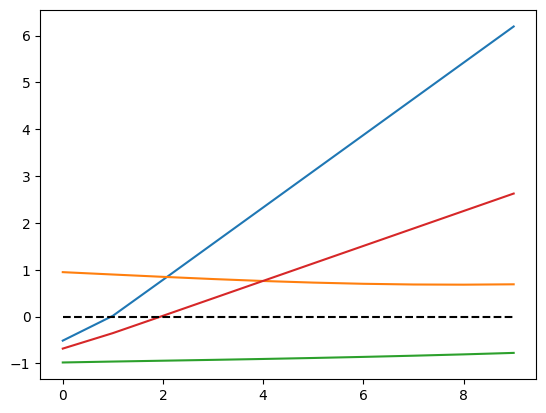

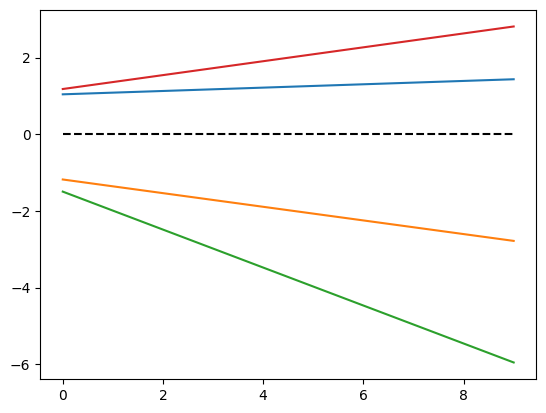

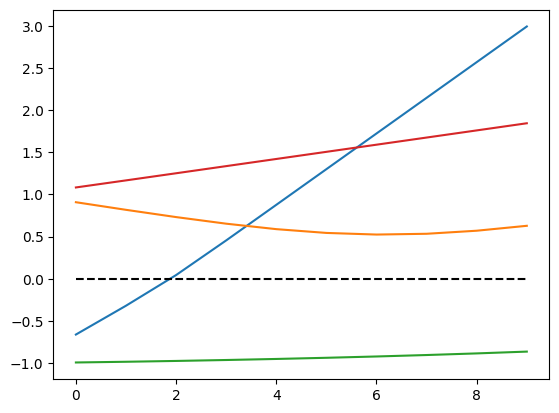

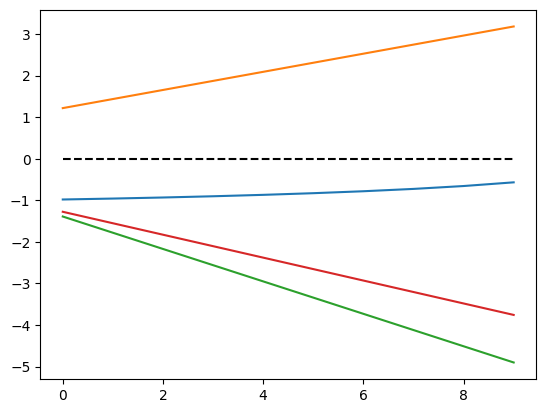

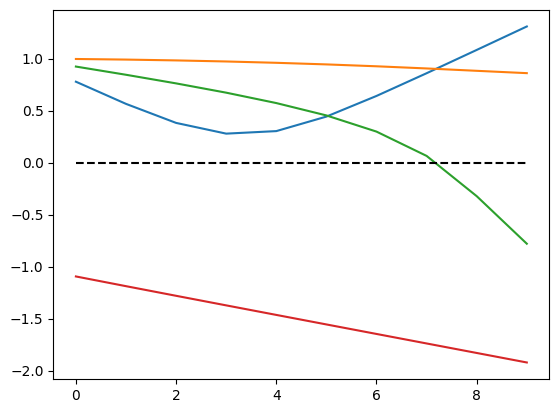

In [106]:
for seed in range(5, 10):
    np.random.seed(seed)
    x = np.random.choice([1.0,-1.0],size=n)
    p = np.random.randn(n)

    x_list = []

    x_new, p_new = leapfrog_integrator(x, p, grad_U, epsilon, L, J, h, alpha)

    plt.plot(np.array(x_list))
    plt.hlines(0,0,len(x_list)-1, colors='k', ls='--')
    plt.show()

In [42]:
grad_U(x, J, h, alpha)

array([ 0.03822127,  0.02707554, -0.14863537, -0.02059067])

In [29]:
problem_inst.E_arr

array([-2.6628432 ,  3.30476615, -1.0654739 , -3.8604549 , -4.4983572 ,
       -3.11412992,  5.58610353, -1.79225952, -3.77875817,  9.24881969,
       -1.46853226,  2.79645526, -7.10394287,  1.34025292,  3.69337447,
        3.37497993])

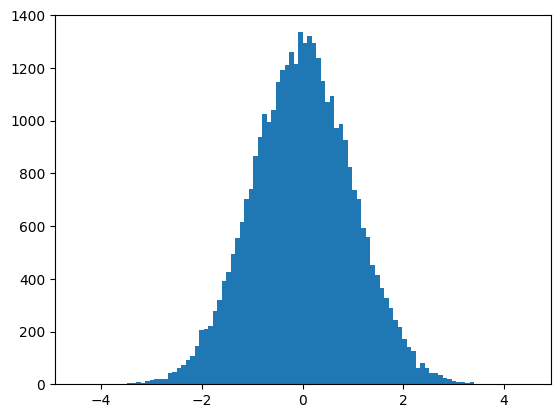

In [26]:
plt.hist(np.reshape(p_global,-1), bins=100)
plt.show()

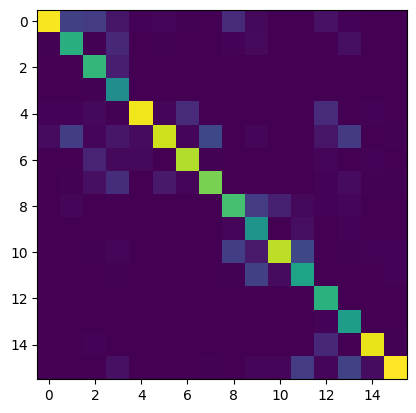

In [5]:
plt.imshow(T)

In [12]:
def all_configs(n):
    return [np.array(v) for v in product([-1, 1], repeat=n)]


def spins_to_int(V):
    """
    V: (..., n) in {-1,+1}. Enumerated via all_configs(n).
    Maps (-1->0, +1->1) with weights 2^(n-1-k) so that
    """
    V = np.asarray(V)
    n = V.shape[-1]
    bits = (V > 0).astype(np.uint64)                      # (..., n)
    weights = (1 << np.arange(n-1, -1, -1, dtype=np.uint64))  # (n,) MSB-first
    return (bits * weights).sum(axis=-1).astype(np.int64)

V = all_configs(3)
spins_to_int(V)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

## Vectorized HMC

In [14]:
def normalize_transition_matrix(T, eps=1e-12, verbose=False):
    T = T.copy()
    T[T < 0] = 0.0
    col_sums = T.sum(axis=0)
    bad = np.abs(col_sums) <= eps
    good = ~bad
    if np.any(good):
        T[:, good] /= col_sums[None, good]
    if np.any(bad):
        T[:, bad] = 1.0 / T.shape[0]
        if verbose:
            print(f"{bad.sum()} columns had near-zero sum. Reset to uniform.")
    return T


def grad_U(X, J, H, alpha):
    """
    X: (Q, n) or (n,) 
    J: (n, n), H: (n,)
    Returns grad shape like X.
    """
    T = np.tanh(alpha * X)                # continuous spins
    sech2 = 1.0 - T*T
    G = T @ J.T                           # vectorized J@T (row-wise)
    return alpha * sech2 * (H + 2.0 * G)


# --- Vectorized leapfrog ---
def leapfrog_integrator_batch(X, P, grad_fn, epsilon, L, J, H, alpha):
    """
    X, P: (Q, n) arrays (Q = batch_samples * num_states)
    grad_fn is called each step (your preference)
    Returns new X, P; does not modify inputs in-place.
    """
    Xn = X.copy()
    Pn = P.copy()

    # half-step momentum
    Pn -= 0.5 * epsilon * grad_fn(Xn, J, H, alpha)

    # L full steps
    for k in range(L):
        Xn += epsilon * Pn
        if k != L - 1:
            Pn -= epsilon * grad_fn(Xn, J, H, alpha)

    # final half-step
    Pn -= 0.5 * epsilon * grad_fn(Xn, J, H, alpha)
    return Xn, Pn


# --- Fully vectorized T-matrix builder (no loops over states/samples) ---
def HMC_T_matrix_vectorized(problem_inst, epsilon=0.1, L=10, alpha=3.0,
                            num_samples=100, num_p_samples=10,
                            pairs_per_batch= 1 << 22,  # controls RAM; raise if you have more
                            seed=None, verbose=False):
    """
    Vectorizes across ALL states and batched samples.
    Only a short loop over batches (for memory) and over L (integrator time).
    """
    rng   = np.random.default_rng(seed)
    J     = np.ascontiguousarray(problem_inst.J_quantum, dtype=np.float64)
    J     = (J + J.T)     # ensure symmetry
    H     = np.asarray(problem_inst.h_quantum, dtype=np.float64)
    n     = int(problem_inst.n)
    beta  = float(problem_inst.T)

    

    m = 1 << n  # number of states

    V0 = np.stack(all_configs(n), axis=0).astype(np.int8)        # (m, n)

    # Map states to indices and initial energies (vectorized)
    state_idx = spins_to_int(V0)               # (m,)
    E_rev = np.asarray(problem_inst.E_arr[::-1], dtype=np.float64)  # (m,)
    U_init_state = E_rev[state_idx]                       # (m,)

    # Continuous x for each state (same magnitude, sign = spin)
    c = np.arctanh(0.999) / alpha
    X0 = (c * V0).astype(np.float64)                      # (m, n)

    # Integer histogram: counts[row=dest_state, col=start_state]
    counts = np.zeros((m, m), dtype=np.int32)

    total_samples = int(num_samples) * int(num_p_samples)
    samples_per_batch = max(1, pairs_per_batch // m)
    if verbose:
        print(f"n={n}, m={m}, total_samples={total_samples}, "
              f"samples_per_batch={samples_per_batch}, L={L}")

    processed = 0
    i_cols = np.arange(m, dtype=np.int64)                 # (m,)

    while processed < total_samples:
        #print(processed, '/', total_samples, ' ' , end='')
        print('.', end='')
        B = min(samples_per_batch, total_samples - processed)  # samples in this batch
        Q = B * m

        # Build flattened batch across ALL columns
        X_flat = np.tile(X0, (B, 1))                      # (Q, n)
        P_flat = rng.normal(size=(Q, n))                  # (Q, n)

        # Initial Hamiltonian
        K0 = 0.5 * np.einsum('ij,ij->i', P_flat, P_flat)  # (Q,)
        col_idx_flat = np.tile(i_cols, B)                 # (Q,)
        U0 = U_init_state[col_idx_flat]                   # (Q,)
        H0 = K0 + U0

        # Integrate (grad called inside leapfrog)
        X1, P1 = leapfrog_integrator_batch(
            X_flat, P_flat, grad_U, epsilon, L, J, H, alpha
        )

        # Final Hamiltonian
        K1 = 0.5 * np.einsum('ij,ij->i', P1, P1)          # (Q,)

        # Discretize: sign(tanh(alpha*X1)) for INDEXING ONLY
        T1 = np.tanh(alpha * X1)
        V1 = np.where(T1 >= 0.0, 1, -1).astype(np.int8)   # (Q, n)
        j_flat = spins_to_int(V1)              # (Q,)

        U1 = E_rev[j_flat]
        H1 = K1 + U1

        # Vectorized accept/reject
        dH = H1 - H0
        acc_prob = np.where(dH <= 0.0, 1.0, np.exp(-beta * dH))
        accept = rng.random(Q) < acc_prob

        dest_flat = np.where(accept, j_flat, col_idx_flat)

        # Scatter-add into histogram
        np.add.at(counts, (dest_flat, col_idx_flat), 1)

        processed += B

    # Probabilities per column
    T = counts.astype(np.float64) / float(total_samples)
    T = normalize_transition_matrix(T, eps=1e-12, verbose=verbose)
    return T


In [17]:
filepath = '/Users/vinit/Downloads/Research/Quantum-Sampling/Manas\' Proposals/'
filename_instances =  '/instances_new.pkl'
sample_size=1000

from tqdm import tqdm
instances = pd.read_pickle(filepath + filename_instances)
tot_instances = np.max(instances['Instance Number'].values)

# results = pd.DataFrame(columns = [
#     'Instance Number',
#     'Spins', 
#     'Temperature', 
#     'Connectivity',
#     'Proposal',
#     'Acceptance',
# #    'Mismatched',
#     'Gap',
#     'Gap Lazy'
#         ])

# T_logmesh = np.logspace(-3, 3, 50)
# T_round = np.sort( np.kron(np.array([1,5]), 10.**np.arange(-3,4)))
# T_lim = np.array([0, np.inf]) 
# T_arr = np.unique( np.concatenate((T_logmesh, T_round, T_lim))) 
# T_arr = [1]
delta_step = 0.2


for instance_num in range(1, tot_instances+1):
    cond  = (instances['Instance Number']==instance_num)
    n            = instances[cond]['Spins'].values[0]
    connectivity = instances[cond]['Connectivity'].values[0]
    J            = instances[cond]['J'].values[0]    #np.triu(np.ones((n,n)),k=1) #
    h            = instances[cond]['h'].values[0]

    print('Starting problem instance', instance_num, 'of', tot_instances, 'with n =', n)

    problem_inst = ProblemInstance(J, h)

    T = 1
    prop_type = 'Continuous-HMC'
    accept_type = 'metropolis'


    problem_inst.T = T

    tm = time.time()
    transition_mat_vec = HMC_T_matrix_vectorized(problem_inst, epsilon=0.2, L=10, alpha=3.0,
                            num_samples=300, num_p_samples=30)
    print("Time for vectorized T-matrix:", time.time() - tm)
    # plt.imshow(transition_mat_vec)
    # plt.colorbar()
    # plt.show()


    # transition_mat = HMC_T_matrix(problem_inst, epsilon=0.2, L=10, alpha=3.0, num_samples=1000, num_p_samples=100)
    # plt.imshow(transition_mat)
    # plt.colorbar()
    # plt.show()

    # plt.imshow(np.abs(transition_mat - transition_mat_vec))
    # plt.colorbar()


    gap, _ = abs_spectral_gap(transition_mat_vec)

    results_datum = {
        'Instance Number': instance_num,
        'Spins': n, 
        'Temperature': T, 
        'Connectivity': connectivity,
        'Proposal': prop_type,
        'Acceptance': accept_type,
        'Gap': gap,
        "delta_time_step_Trotter": delta_step
    }


    print("Instance {}, T = {}, Proposal = {}, Acceptance = {}, Gap = {:.4f}".format(
        instance_num, T, prop_type, accept_type, gap))
    
    #results = pd.concat([results,pd.DataFrame([results_datum])], ignore_index=True)

    results_row = pd.DataFrame([results_datum])
    results_row.to_csv('results_HMC.csv', mode='a', header=not os.path.exists('results_HMC.csv'), index=False)
    

    
    # #Sampling
    # empirical_dist, key_list = Sampling_MCMC_trajectories(problem_inst, 
    #                                     Transition_matrix=transition_mat, sample_size=sample_size, burn=sample_size//10)

    # fig, ax = plt.subplots(1, figsize=(7,4))
    # if prop_type == 'quantum_time_mid_gamma_mid_Trotter':
    #     prop_type = 'quantum_circ'
    # ax.plot(empirical_dist, label=prop_type + ' n={}'.format(problem_inst.n))
    # exact_dist = np.exp(-problem_inst.T*problem_inst.E_arr[::-1])
    # exact_dist = exact_dist / np.sum(exact_dist)

    # ax.plot(exact_dist, marker='o', linestyle='dashed', label='exact,  n={}'.format(problem_inst.n))
    
    # ax.set_xlabel("Configurations(s)", fontsize=16)
    # ax.set_ylabel("P(s)", fontsize=16)
    # ax.legend(loc='best', fontsize=12)
    # ax.tick_params(axis='both', which='major', labelsize=12)
    # plt.savefig(os.getcwd() + "/Figures/{}_vs_configs_n_{}.png".format(prop_type, problem_inst.n), bbox_inches='tight')
    # plt.show()

#results.to_pickle('results_new_all_prop.pkl')

Starting problem instance 1 of 2000 with n = 3
.Time for vectorized T-matrix: 0.054251670837402344
Instance 1, T = 1, Proposal = Continuous-HMC, Acceptance = metropolis, Gap = 0.0574
Starting problem instance 2 of 2000 with n = 4
.Time for vectorized T-matrix: 0.17359542846679688
Instance 2, T = 1, Proposal = Continuous-HMC, Acceptance = metropolis, Gap = 0.0069
Starting problem instance 3 of 2000 with n = 5
.Time for vectorized T-matrix: 0.7978329658508301
Instance 3, T = 1, Proposal = Continuous-HMC, Acceptance = metropolis, Gap = 0.0321
Starting problem instance 4 of 2000 with n = 6
.Time for vectorized T-matrix: 1.6872835159301758
Instance 4, T = 1, Proposal = Continuous-HMC, Acceptance = metropolis, Gap = 0.0060
Starting problem instance 5 of 2000 with n = 7
.Time for vectorized T-matrix: 3.874591112136841
Instance 5, T = 1, Proposal = Continuous-HMC, Acceptance = metropolis, Gap = 0.0238
Starting problem instance 6 of 2000 with n = 8
.Time for vectorized T-matrix: 8.8038182258605

## Tests

In [ ]:
def test_grad_vectorization(J, h, alpha, n, Q=17, seed=0, atol=1e-12):
    rng = np.random.default_rng(seed)
    X  = rng.normal(size=(Q, n))
    g1 = grad_U(X, J, h, alpha)                   # vectorized call
    g2 = np.vstack([grad_U(x, J, h, alpha) for x in X])  # rowwise
    assert np.allclose(g1, g2, atol=atol), np.max(np.abs(g1-g2))
    print("[OK] grad_U vectorization")

n = problem_inst.n
test_grad_vectorization(problem_inst.J_quantum, problem_inst.h_quantum, alpha=3.0, n=n)


[OK] grad_U vectorization


In [ ]:
def test_leapfrog_equivalence(J, h, alpha, n, epsilon=0.05, L=7, seed=1, Q=11, atol=1e-10):
    rng = np.random.default_rng(seed)
    X  = rng.normal(size=(Q, n))
    P  = rng.normal(size=(Q, n))

    # scalar loop (original)
    Xs, Ps = [], []
    for i in range(Q):
        xi, pi = leapfrog_integrator(X[i], P[i], grad_U, epsilon, L, J, h, alpha)
        Xs.append(xi); Ps.append(pi)
    Xs = np.vstack(Xs); Ps = np.vstack(Ps)

    # batch (vectorized)
    Xb, Pb = leapfrog_integrator_batch(X, P, grad_U, epsilon, L, J, h, alpha)

    assert np.allclose(Xs, Xb, atol=atol), np.max(np.abs(Xs-Xb))
    assert np.allclose(Ps, Pb, atol=atol), np.max(np.abs(Ps-Pb))
    print("[OK] leapfrog scalar vs batch")

test_leapfrog_equivalence(problem_inst.J_quantum, problem_inst.h_quantum, alpha=3.0, n=n)


[OK] leapfrog scalar vs batch
